In [ ]:
from shapely.geometry import Polygon      
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from utils import SensorCamera, CoverageNode, Tree
from utils import lawmowerPath

DJImini3Camera = SensorCamera()
eps = 1e-6
desirableGSD = 1*0.43 #cm/px
altitude = DJImini3Camera.h_desirable(desirableGSD)/100
width,height = DJImini3Camera.l(altitude) # dimensão horizontal do sensor para a altitude desejada
poly = Polygon([(-6*height, -6*width), (6*height, -6*width), (6*height, 6*width), (-6*height, 6*width)])
angle_deg = 0  # ângulo da varredura em graus (0 = horizontal, 90 = vertical)
waypointsLawMower = lawmowerPath(poly, height, width, angle_deg)

areas_de_interesse = []
area_de_interesse = Polygon([(0, -1.2*width*2), (1.2*height*2,  -1.2*width*2), (1.2*height*2,0), (0,0)])
areas_de_interesse.append(area_de_interesse)


In [3]:
# for others coverages plnas
altitude2 = DJImini3Camera.h_desirable(4*desirableGSD)/100
width2,height2 = DJImini3Camera.l(altitude2) # dimensão horizontal do sensor para a altitude desejada
waypointsInitial = lawmowerPath(poly, height2, width2, angle_deg)


In [4]:
LawnmowerTree = Tree(sensorCamera=DJImini3Camera)
BFTree = Tree(sensorCamera=DJImini3Camera)
DFTree = Tree(sensorCamera=DJImini3Camera)
ShortTree = Tree(sensorCamera=DJImini3Camera)

LawnmowerTree.add_fistLevel_nodes(waypointsLawMower, altitude,width,height)
BFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
ShortTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)

In [5]:
# Depth-First 
for i,node in enumerate(DFTree.nodes):
    if(any(p.intersection(node.polygon).area/p.area >= 0.05 for p in areas_de_interesse)):
        if(i < len(DFTree.nodes)-1):
            if(np.sign(DFTree.nodes[i+1].x - node.x) != 0):
                sentido = np.sign(DFTree.nodes[i+1].x - node.x)
        children = node.found_children_grid(2,DJImini3Camera,sentido)
        for child in children:
            if(any(p.intersection(child.polygon).area/p.area >= 0.02 for p in areas_de_interesse)):
                node.add_children(child)
                children2 = child.found_children_grid(2,DJImini3Camera,sentido)
                for child2 in children2:
                    if(any(p.intersection(child2.polygon).area/p.area >= 0.02 for p in areas_de_interesse)):
                        child.add_children(child2)


In [6]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list(
    "azul_verde_vermelho",
    [(0.0, "blue"), (0.5, "green"), (1.0, "red")]
)

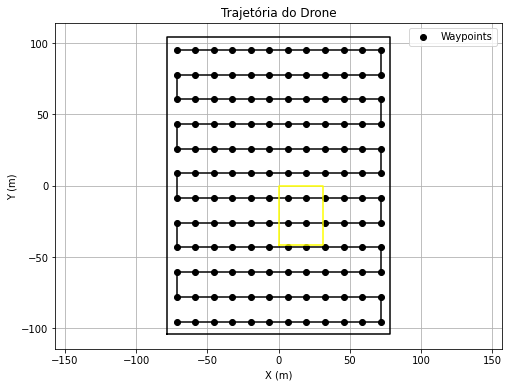

Coverage Path length (LawMower):  1.907136000000005  km


In [7]:
waypoints = np.array(waypointsLawMower)
fig, ax = plt.subplots(figsize=(8, 6))
waypoints_x = [wp[0] for wp in waypoints]
waypoints_y = [wp[1] for wp in waypoints]
ax.scatter(waypoints_x, waypoints_y, color='black', label='Waypoints', marker='o')
ax.plot(waypoints_x, waypoints_y, color='black')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black')
x, y = area_de_interesse.exterior.xy
ax.plot(x, y, color='yellow')
plt.title('Trajetória do Drone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
path_length = 0
for i in range(np.size(waypoints,0)-1):
    path_length += np.linalg.norm(waypoints[i+1] - waypoints[i])
print("Coverage Path length (LawMower): ", path_length/1000, " km")

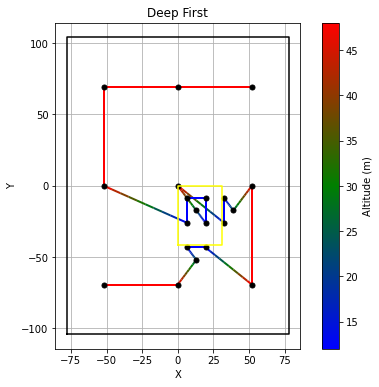

Coverage Path length (Deep First):  0.7019279137838137  km


In [8]:
waypointsDF = []
for node in DFTree.nodes:
    waypointsDF.append([node.x, node.y, node.Altitude])
    if(node.children):
        for child in node.children:
            waypointsDF.append([child.x, child.y, child.Altitude])
            for child2 in child.children:
                waypointsDF.append([child2.x, child2.y, child2.Altitude])
waypointsDF = np.array(waypointsDF)

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsDF) - 1):
    segment = interp_segment(waypointsDF[i], waypointsDF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsDF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.plot(waypointsDF[:, 0], waypointsDF[:, 1], 'o', color='black', markersize=5)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black')
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='yellow')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Deep First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsDF,0)-1):
    path_length += np.linalg.norm(waypointsDF[i+1] - waypointsDF[i])
print("Coverage Path length (Deep First): ", path_length/1000, " km")




In [9]:
Lawnmower = []
# 10% interesting results 
#patches = 1
